# Parametric projected trap array simulations
the premier high-level notebook in the projected trap array analysis. 
trap arrays can be generated for several configurations given a list of params,
and the simulation data can be saved with sensible names automatically.

for now, this is only intended to handle monochromatic spatially coherent fields.

In [1]:
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import namedtuple
from numpy import real,empty
from time import time
import csv

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from simfuncs import * # for saving/retreiving data

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
# imagedir = os.path.join('..','images')
imagedir = os.path.join('.','paper_data')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

images saved in .\paper_data


## XY Plots
Intensity slice in x-y plane, where z is the propagation axis

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 20 # number of grid points in each dimension
pts = 801 ##1100 # grid mesh is pts x pts

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None]) 

In [3]:
## the Gaussian beams arrays to generate

a = 1e-4
d = 4.3*a
ta1 = sqrt(0.082) # spot transmittivity for a dark mask
tb1 = 1 # background transmittivity

configurations = [
                    gba('dmd',a,1,0,d,d)
#                     gba('bright',a,0,1,d,d),
#                     gba('bright_phases',a,0,1,d,d,phi_std=0.2),
#                     gba('bright_pos',a,0,1,d,d,pos_std=0.2*a),
#                     gba('bright_asym',a,0,1,d,1.22*d),
#                     gba('dark',a,tb1,ta1,d,d),
#                     gba('dark_pos',a,tb1,ta1,d,d,pos_std=0.2*a),
#                     gba('dark_asym',a,tb1,ta1,d,1.22*d),
#                     gba('bright_dark',a,0.77,0.77*ta1,d,d,a2=a)
                ] 

# custom colormap
n_bin = 100
# colorlist = [(0, 0, 0), (1, 0, 0)]  # black to red
# colorlist = [(0, 0, 0),(249/255,15/255,15/255),(249/255, 239/255, 239/255)] # black-red-pink
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red2
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red3

# cmap = LinearSegmentedColormap.from_list('my_cmap', colorlist, N=n_bin)
cmap = 'jet'

b=0.002516, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
wrote data to .\paper_data\dmd_input_1642430362.csv
wrote data to .\paper_data\dmd_focus_1642430362.csv
wrote data to .\paper_data\dmd_talbot_1642430363.csv
step 0 completed


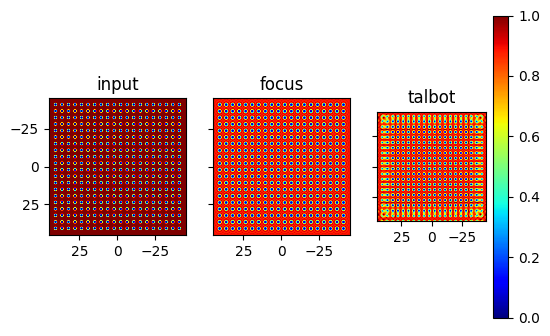

In [5]:
plot=True
savedata=True

labels = ['input','focus','talbot'] # output axial plane

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
        else:
            talbot_field = field2
           
    if plot:
        fig,axes = plt.subplots(ncols=3,sharey=True,dpi=100)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            if l == labels[-1]:
                fig.colorbar(cax)
        
        if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

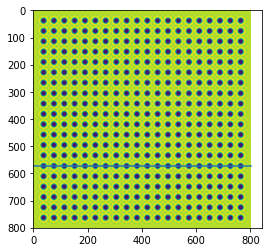

In [10]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(focal_field)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

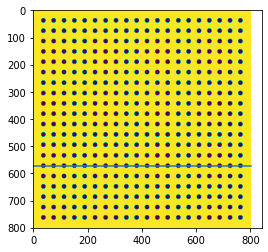

In [21]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(field0)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

No handles with labels found to put in legend.


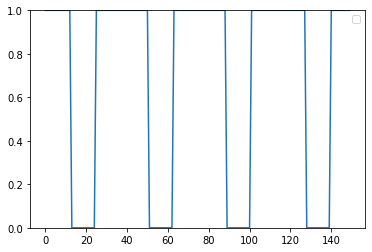

In [19]:
plt.plot(abs(field0[yb+3,400:550])**2/amax(abs(field0)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
plt.legend()

In [157]:
sqrt(.5)

0.7071067811865476

In [158]:
sqrt(2)/2

0.7071067811865476

(0.0, 1.0)

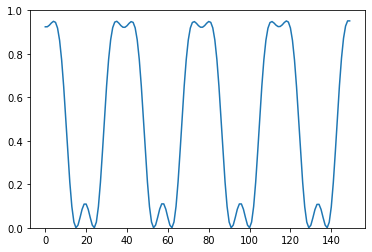

In [33]:
# for i in range(5):
plt.plot(abs(focal_field[yb,400:550])**2/amax(abs(focal_field)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
# plt.legend()

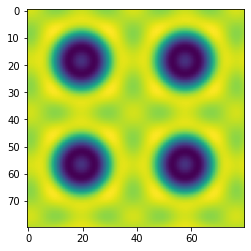

In [31]:
plt.imshow(abs(focal_field[yb-20:yb+60,400:480])**2/amax(abs(focal_field)**2))

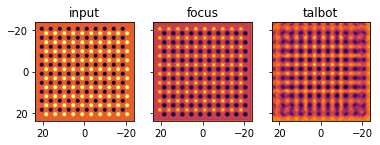

In [70]:
fig,axes = plt.subplots(ncols=3,sharey=True)#,dpi=100)

for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))    
  

In [48]:
x2pts[0],x2pts[-1]

(-2.362849999999996e-05, 2.362849999999996e-05)

## parameter scan
one basic mask configuration, but scan over a particular parameter, e.g. iris radius b

In [34]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 20 # number of grid points in each dimension
pts = 801 ##1100 # grid mesh is pts x pts

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None]) 

In [35]:
## the Gaussian beams arrays to generate

a = 1e-4
d = 4.3*a
ta1 = 0 # spot transmittivity for a dark mask/ reflectivity if using a DMD
# tb1 = 1 # background transmittivity/ reflectivity if using a DMD

configurations = [
                    gba('dmd',a,tb1,ta1,d,d)
                ] 

# custom colormap
n_bin = 100
# colorlist = [(0, 0, 0), (1, 0, 0)]  # black to red
# colorlist = [(0, 0, 0),(249/255,15/255,15/255),(249/255, 239/255, 239/255)] # black-red-pink
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red2
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red3

# cmap = LinearSegmentedColormap.from_list('my_cmap', colorlist, N=n_bin)
cmap = 'jet'

In [38]:
b = f1*3.8317/(a*k)
print(b)
steps = linspace(0.8*b,1.2*b,5)
steps

0.0025155652312115135


array([0.00201245, 0.00226401, 0.00251557, 0.00276712, 0.00301868])

In [67]:
## scan the iris size

plot=False
savedata=False

labels = ['input','focus','talbot'] # output axial plane

b0 = f1*3.8317/(a*k)
bsteps = linspace(0.5*b0,1*b0,10)
    
focal_soln = []

for i,b in enumerate(bsteps):
    
    # extract the array params
    name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda 
    zTalboty = 2*Ly2**2/lmbda
#     b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
#         b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
            focal_soln.append(focal_field)
        else:
            talbot_field = field2
           
    if plot:
        fig,axes = plt.subplots(ncols=3,sharey=True,dpi=100)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, b={b}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            if l == labels[-1]:
                fig.colorbar(cax)
        
        if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

b=0.001258, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001398, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001537, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001677, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001817, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001957, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002096, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002236, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002376, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002516, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045


In [68]:
bsteps/b0

array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])

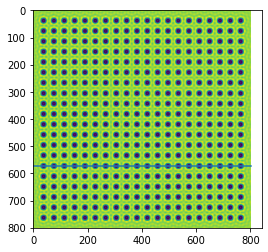

In [58]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(focal_field)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

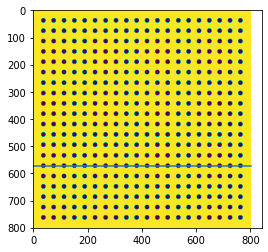

In [59]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(field0)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

No handles with labels found to put in legend.


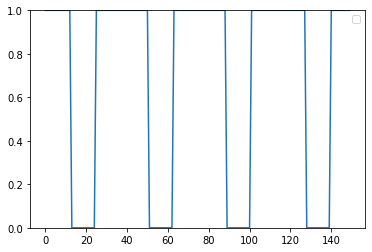

In [44]:
plt.plot(abs(field0[yb+3,400:550])**2/amax(abs(field0)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
plt.legend()

In [61]:
steps/b

array([0.66666667, 0.75      , 0.83333333, 0.91666667, 1.        ])

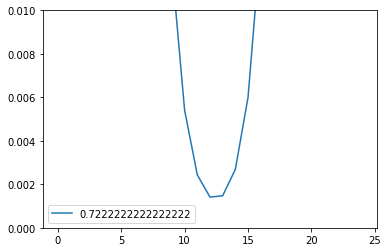

In [99]:
# j = 115
# for step,field in zip(bsteps,focal_soln):
#     plt.plot(abs(field[yb,445+j:470+j])**2/amax(abs(field)**2),label=step/b0)
#     # plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
    
field = focal_soln[4]
step = bsteps[4]
plt.plot(abs(field[yb,445:470])**2/amax(abs(field)**2),label=step/b)
# field = focal_soln[-1]
# step = bsteps[-1]
# plt.plot(abs(field[yb,400:550])**2/amax(abs(field)**2),label='b')#step/b)

plt.ylim((0,.01))
plt.legend()

Text(0, 0.5, 'log(trap center intensity)')

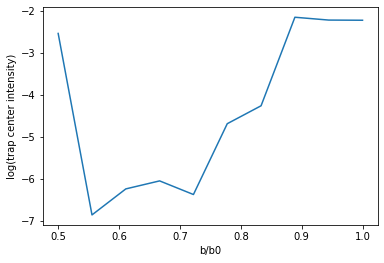

In [96]:
centers = [abs(field[yb,572])**2/amax(abs(field)**2) for field in focal_soln]
plt.plot(bsteps/b0,np.log(centers))
plt.xlabel("b/b0")
plt.ylabel("log(trap center intensity)")

In [56]:
steps/b

array([0.8, 0.9, 1. , 1.1, 1.2])

In [55]:
steps = linspace(0.8*b,1.2*b,5)
steps/b

array([0.8, 0.9, 1. , 1.1, 1.2])

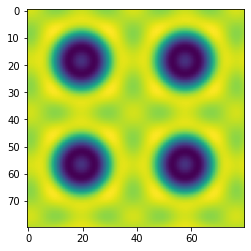

In [31]:
plt.imshow(abs(focal_field[yb-20:yb+60,400:480])**2/amax(abs(focal_field)**2))

## XZ Plots
Intensity slice in x-z plane, where z is the propagation axis

## T=0.49 mask
the real mask we have in the lab

In [208]:
## physics and lens params
lmbda = 8.08e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = .005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
pts = 1001 # grid mesh is pts x pts
phi = 140

# calculate the Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda
    
numsteps = 20 # zsteps to compute. should be odd number
z2steps = lambda zT: linspace(0,3.6e-3,numsteps)
b = 1e-3

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [209]:
## the Gaussian beam arrays to generate

a = 1e-4
d = 4.3*a
ta1 = sqrt(0.49) # spot transmittivity for a dark mask
tb1 = 1 # background transmittivity

configurations = [
                    gba('dark',a,tb1,ta1,d,d)
                 ] 

(-3.141592653589793, 3.141592653589793)

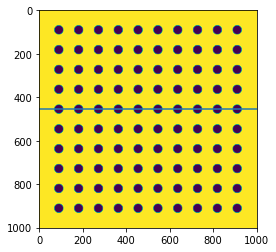

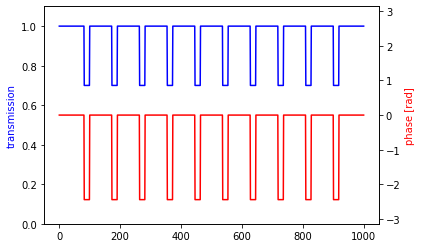

In [210]:
name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]
       
mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                       phi_std=phi_std, pos_std=pos_std, 
                       aperture=ta1, plate=tb1)

complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
spot_phases *= exp(-1j*phi*pi/180)
phase_mask = spot_phases + complement
mask *= phase_mask
field0 = mask

mask = real(field0)
plt.imshow(mask)
# mask = mask[1:,1:]
plt.imshow(mask)
# plt.plot([0,mask.shape[0]-1],[(mask.shape[1]-1)/2,(mask.shape[1]-1)/2])
# plt.plot([(mask.shape[0]-1)/2,(mask.shape[0]-1)/2],[0,mask.shape[1]-1])
xslice = 453
plt.axhline(xslice)

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1.1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

b=0.001000, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
obtained normalization factor
step 19 completed


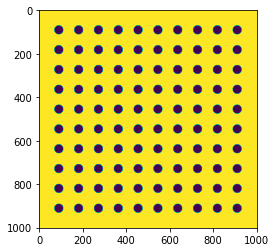

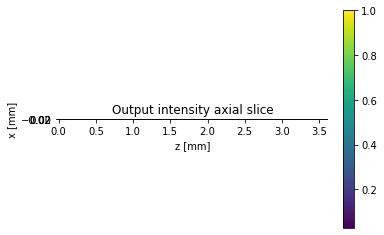

In [251]:
plot=True
padding = 3*pts//2 #TODO set
# savedata=True

xyslices = []

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,r1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
#     b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)
    complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
    spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement
    mask *= phase_mask

    print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
    print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    zTalbot = max(zTalbotx,zTalboty)
    z2 = f2
#     dz2_steps = linspace(-zTalbot*depth,zTalbot*depth,numsteps)
    dz2_steps = z2steps(zTalbot)
    I2max = 1
    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)

    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        if dz2 == 0:
            I2max = max(abs(field2[:,xslice])**2)
            Ixymax = amax(abs(field2)**2)
            print("obtained normalization factor")

        slices_soln[:,i] = abs(field2[:,xslice])**2/I2max
        xyslices.append(abs(field2)**2/Ixymax)
#         print(f"axial plane {i} completed")
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
print(f"step {i} completed")

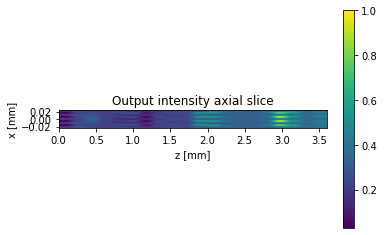

In [252]:
fig,ax = plt.subplots()
mmscl = 1e3
M = f2/f1
roi = 300
cax = ax.imshow(slices_soln[roi:pts-roi,:], extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_title("Output intensity axial slice")

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
ax.set_aspect(5)
cbar = fig.colorbar(cax)

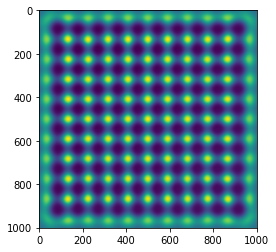

In [253]:
plt.imshow(real(xyslices[0]))

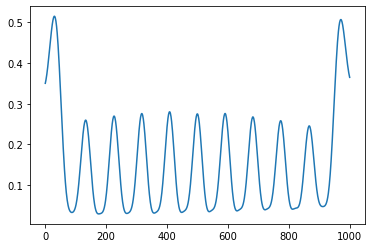

In [254]:
plt.plot(xyslices[0][453])

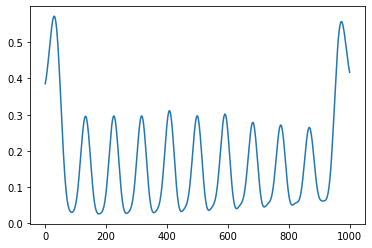

In [242]:
plt.plot(slices_soln[:,0])

In [201]:
 xslice

455

In [126]:
slices_soln.shape

(1001, 20)

## Paper

In [3]:
## physics and lens params
lmbda = 8.05e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = .005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 1 # number of grid points in each dimension
pts = 1001 # grid mesh is pts x pts
numsteps = 101 # zsteps to compute. should be odd number
depth = 1 # fraction of Talbot length to scan about either side z2 = f2
z2steps = lambda zT: linspace(0,zT*depth,numsteps)

# Gaussian beam array object.
param_names = ['type','a1','t1','r1','dx','dy','a2','r2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None]) 

In [4]:
## the Gaussian beams arrays to generate

a = 1e-4
d = 4*a
r = 1/sqrt(1.968)

configurations = [
                    gba('bright',a,0,0,d,d),
#                     gba('bright_phases',a,0,0,d,d,phi_std=0.2),
#                     gba('bright_pos',a,0,0,d,d,pos_std=0.2*a),
#                     gba('bright_asym',a,0,0,d,1.22*d),
                    gba('dark',a,1,r,d,d)
#                     gba('dark_pos',a,1,r,d,d,pos_std=0.2*a),
#                     gba('dark_asym',a,1,r,d,1.22*d),
#                     gba('bright_dark',a,0.8,r,d,d,a2=a,r2=0.5)
                ]      

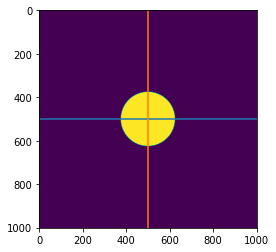

In [5]:
name,a1,t1,r1,dx,dy,a2,r2,phi_std,pos_std = [
        getattr(configurations[0], attr) for attr in param_names]
mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=1-r1, plate=t1)
mask = real(mask)
plt.imshow(mask)
# mask = mask[1:,1:]
plt.imshow(mask)
# plt.xlim(((mask.shape[0]-1)/2),0)
# plt.ylim(((mask.shape[1]-1)/2),0)
plt.plot([0,mask.shape[0]-1],[(mask.shape[1]-1)/2,(mask.shape[1]-1)/2])
plt.plot([(mask.shape[0]-1)/2,(mask.shape[0]-1)/2],[0,mask.shape[1]-1])
# plt.plot(real(mask)[500,:])
# plt.plot([500,500],[1,0])
# plt.plot([500,610],[0.5,0.5])
# plt.plot([390,500],[0.5,0.5])
# plt.xlim(350,650)

In [6]:
k

0.0004

b=0.002455, a=0.0001, dx=0.0004, dy=0.0004, xnum=1, ynum=1
zTalbotx=0.000040, zTalboty=0.000040
obtained normalization factor
wrote data to .\paper_data\bright_axial_1626964002.csv
b=0.002455, a=0.0001, dx=0.0004, dy=0.0004, xnum=1, ynum=1
zTalbotx=0.000040, zTalboty=0.000040
obtained normalization factor
wrote data to .\paper_data\dark_axial_1626964104.csv
step 100 completed


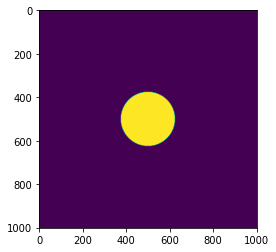

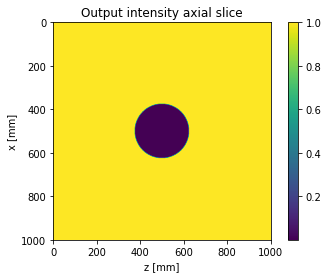

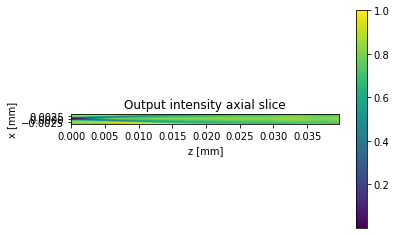

In [90]:
plot=True
# savedata=True

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,r1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
                
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    zTalbot = max(zTalbotx,zTalboty)
    z2 = f2
#     dz2_steps = linspace(-zTalbot*depth,zTalbot*depth,numsteps)
    dz2_steps = z2steps(zTalbot)
    I2max = 1
    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    xslice = pts//2 # x coordinate of the slice
    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        if dz2 == 0:
            I2max = max(abs(field2[:,xslice])**2)
            print("obtained normalization factor")

        slices_soln[:,i] = abs(field2[:,xslice])**2
#         print(f"axial plane {i} completed")
    
    for i in range(numsteps):
        slices_soln[:,i] /= I2max
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
print(f"step {i} completed")

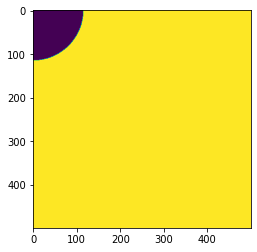

In [33]:
fig,ax = figax()
ax.imshow(real(mask)[pts//2:,pts//2:])

## Test

In [12]:
## physics and lens params
lmbda = 8.05e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
pts = 1100 # grid mesh is pts x pts

In [16]:
# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [27]:
array = gba('bright',1e-4,0,sqrt(1),4.3e-4,4.3e-4)
# name,a,t,r,dx,dy = array
array

gba(type='bright', a1=0.0001, tb1=0, ta1=1.0, dx=0.00043, dy=0.00043, a2=None, tb2=None, phi_std=None, pos_std=None)

In [32]:
# reproduce standard bright array and save the image data

# list of gba configurations over which to iterate
configurations = [gba('bright',1e-4,0,sqrt(1),4.3e-4,4.3e-4)]#,
#                   gba('bright_asym',1e-4,0,0,4.3e-4,1.22*4.3e-4)]

b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
step 0 completed


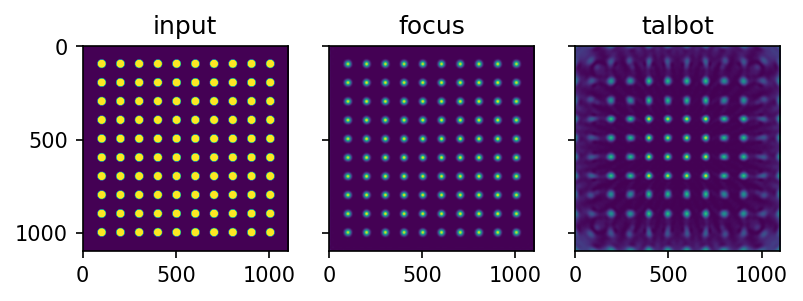

In [33]:
plot=True
savedata=False

labels = ['input','focus','talbot'] # output axial plane

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,ta1,dx,dy,a2,tb2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda 
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
        else:
            talbot_field = field2
           
    if plot:
        fig,axes = plt.subplots(ncols=3,sharey=True,dpi=150)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, tb2={tb2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            mmscl = 1e3
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy) #,extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))    
        
        if savedata:
            fname = f'test_{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

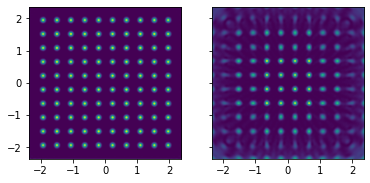

In [34]:
# SAVE OUTPUT INTENSITIES

fig,axes = plt.subplots(ncols=2,sharey=True)

for output_field,z2,ax in zip([focal_field,talbot_field],zvals,axes):
    I2_xy = conjugate(output_field)*output_field
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max
    I2_xy = real(I2_xy)

    # plot
    
#     ax.set_title(rf'Intensity') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
    mmscl = 1e3
    ax.set_aspect('equal')
    cax = ax.imshow(I2_xy,extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
    cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)

#         save intensity data as a csv

In [ ]:
fig,axes = plt.subplots((1,2),sharey=True)

### low level tests

In [168]:
## functions to save array data

# only store non-complex data

def soln_to_csv(fname, data, labels, metastr=None):
    """
    Args:
        fname: myfile.csv
        data: a list or array of equal length lists or arrays of data
        labels: a label describing each list in data. None by default.
    
        e.g., 
        data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
        labels = ['x', '2x', 'x^2']
    """
    
    
    if type(data) == np.ndarray:
    # listify to avoid malforming strings
        data = [d for d in data]
    
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')

        if metastr:
            writer.writerow([metastr])
        
        if labels:
            for d,l in zip(data, labels):
                writer.writerow([l] + list(d))
        
        else:
            for d in data:
                writer.writerow(d)
            
    print(f"wrote data to {fname}")

def soln_from_csv(fname, labels=True, metastr=False, datatype=complex):
    """
    Args:
        fname: myfile.csv
        labels: if True, assume the zeroth element of each row
        contains labels for the columns of data
        metastr: if True, will interpret the first row of the data as
        a string which is not part of the data. False by default
        datatype: a python datatype. complex by default
    Returns:
        data: an array of equal length arrays of data
        labels: a label describing each array in data if labels is True
        metadata: if metastr is True, a str found at the start of the file
    
        e.g. 
            data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
            labels = ['x', '2x', 'x^2']
            metadata = 'something about my data'
            
            
    """
    labels = []
    data = []
    
    with open(fname, 'r', newline='') as f:
        reader = csv.reader(f, delimiter=',')
        if metastr:
            metadata = next(reader)
        
        idx = 1 if labels else 0
        
        for row in reader:
            if labels:
                labels.append(row[0])
            try:
                data.append(np.array([datatype(x) for x in row[idx:]]))
            except (ValueError,TypeError) as e:
                print(e)
                print(f"problematic row: {row}")
                break
    
    if labels and metastr:
        return data, labels, metadata
    if labels:
        return data, labels
    if metastr:
        return data, metadata
    else: 
        return data

In [118]:
datatype = complex

In [119]:
type(1+1j) == datatype

True

In [112]:
labels = False
idx

0

In [87]:
[f.shape for f in field2[:5]]

[(1100,), (1100,), (1100,), (1100,), (1100,)]

In [95]:
metadata = f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
r1={r1}, t1={t1}, a2={a2}, r2={r2}"

In [96]:
metadata

'lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None'

In [109]:
abs(1+1j)

1.4142135623730951

In [110]:
# test function saving

fname = 'test.csv'
filepath = os.path.join(imagedir,fname)
soln_to_csv(filepath,abs(talbot_field),labels=None,metastr=metadata)

wrote data to .\paper_data\test.csv


In [121]:
data, metastr = soln_from_csv(filepath,labels=False,metastr=True,
                              datatype=float)

In [122]:
metastr

['lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None']

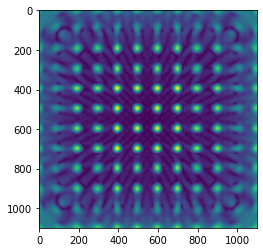

In [123]:
plt.imshow(data)